# Advanced Lane Lines

### Initial Camera Calibration

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
from CameraOperations import show_grid, correct_distortion, calibrate_camera_from_folder
import os
import pickle

print("Calibrating camera on images in camera_cal...")
%time mtx, dist = calibrate_camera_from_folder("./camera_cal",name_pattern="calibration*.jpg", counts=(9,6))
print("Done Calibrating.")
global_mtx = mtx
global_dist = dist

print("Correcting calibration images...")
test_images = os.listdir("camera_cal/")
i = 0
for img in test_images:
    cal_image = mpimg.imread('camera_cal/'+img)
    cal_un_dst = correct_distortion(cal_image, global_mtx, global_dist)
    if i==0:
        show_grid((cal_image, cal_un_dst), ("Orginal Image", "Undistorted Image"), ticks=(320,80))
    i += 1
    mpimg.imsave("corrected_images/adj_"+img, cal_un_dst)

# Correct the test images
print("Correcting test images...")
test_images = os.listdir("test_images/")
for img in test_images:
    image = mpimg.imread('test_images/'+img)
    un_dst = correct_distortion(image, global_mtx, global_dist)
    mpimg.imsave("corrected_images/adj_"+img, un_dst)
    
show_grid((image, un_dst), ("Test Image", "Corrected Test Image"), ticks=(320,80))
#global_mtx, global_dist

#Save a dictionary to a pickle file
pickle_dict = {'mtx': global_mtx, 'dist': global_dist}
pickle.dump(pickle_dict, open("./camera_parameters.p", "wb"))

### Test on a few images

[[540, 465], [740, 465], [1280, 720], [0, 720]]
Left Radius: 0.0, Distance from center: 0.00m
Right Radius: 0.0, Distance from center: 0.00m


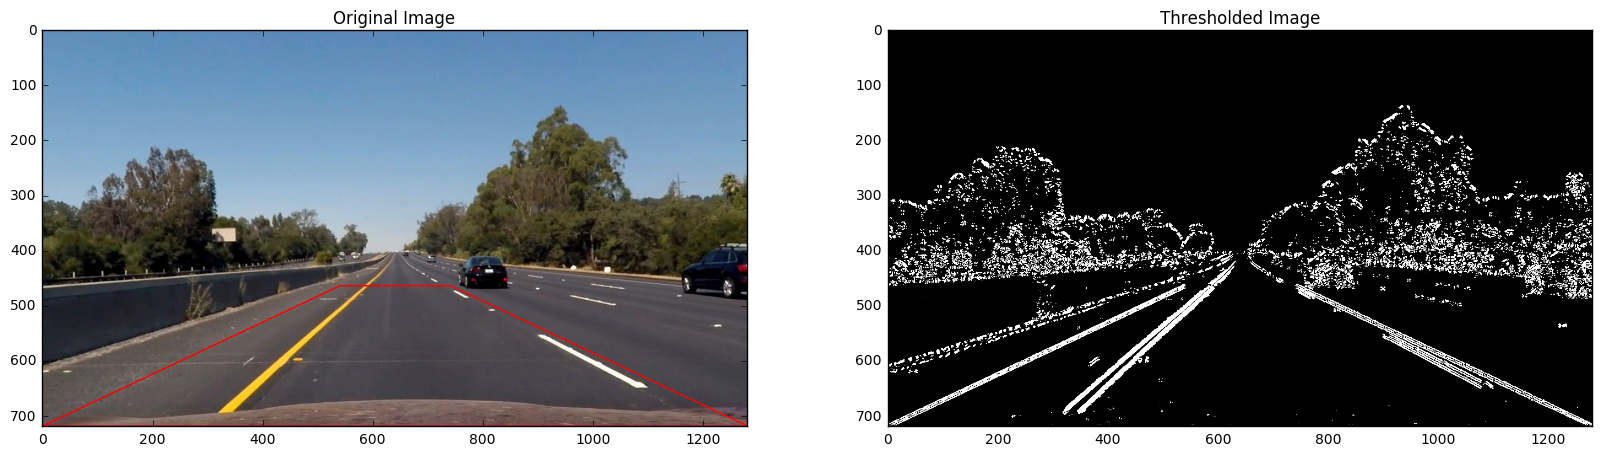

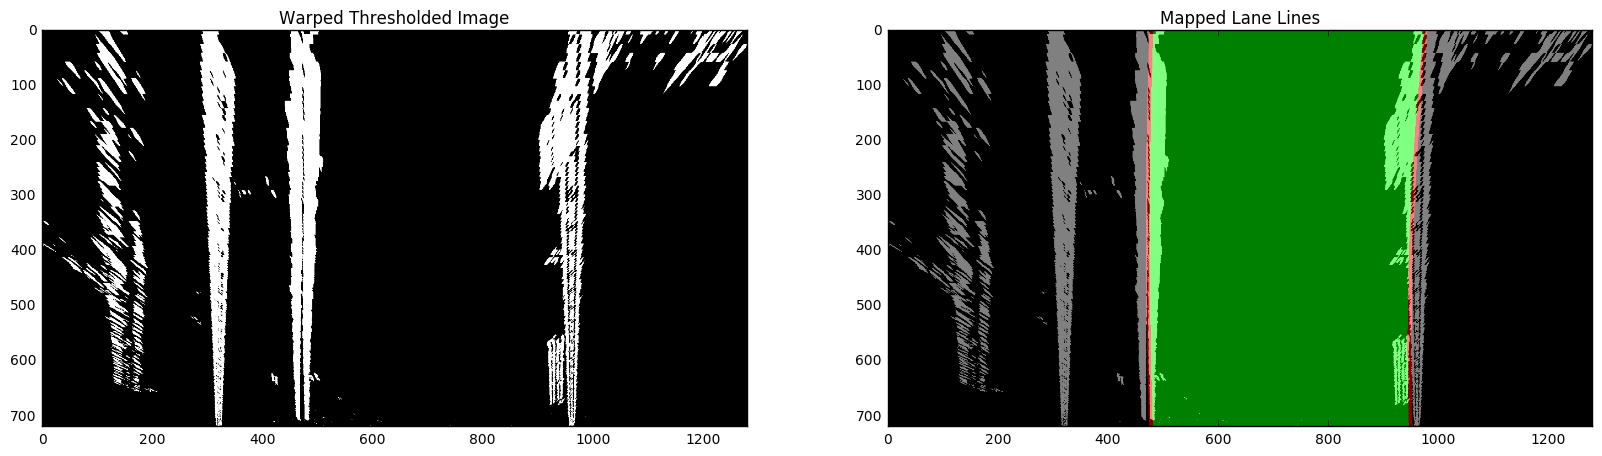

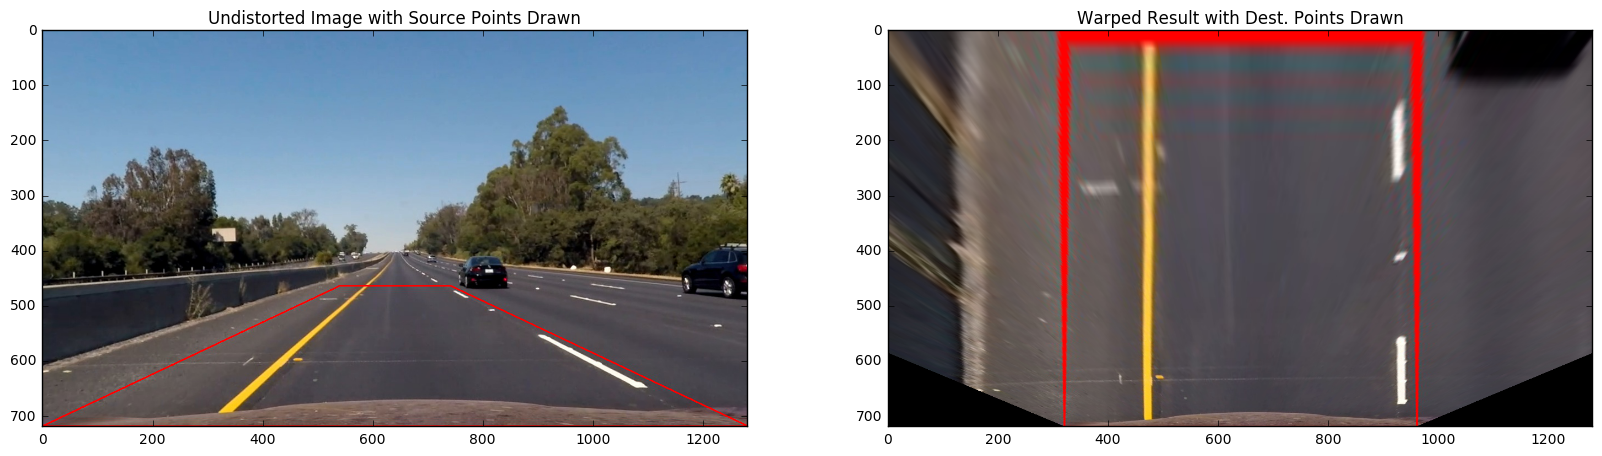

In [3]:
from LaneLines import Road
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from CameraOperations import show_grid, sobel_LS_threshold
%matplotlib inline
import cv2

#image = mpimg.imread('corrected_images/adj_straight_lines1.jpg')
image_id = 1260
image = mpimg.imread('debug_images/{0}.jpg'.format(image_id))
road = Road(window_height=48, window_width=50, margin=50, w=1280, h=720)
img_thres = road.image_threshold(image)
warped = road.perspective_transform(img_thres)
road.parse_image(image)
road.sobel_kernel=15
overlay, mapped_lanes = road.draw_overlay(image, warped)

show_grid((image, img_thres), ("Original Image", "Thresholded Image"))

show_grid((warped, mapped_lanes), ("Warped Thresholded Image", "Mapped Lane Lines"))

for k in range(len(road.viewport)):
    x1, y1 = road.viewport[k][0],road.viewport[k][1]
    x2, y2 = road.viewport[k-1][0],road.viewport[k-1][1]
    cv2.line(image,(x1,y1),(x2,y2), [255,0,0], 2)
warped_orig = road.perspective_transform(image)
show_grid((image, warped_orig), ("Undistorted Image with Source Points Drawn", "Warped Result with Dest. Points Drawn"))

#show_grid((image, img_thres, overlay), ("Original", "Thresholded", "overlay"))
#show_grid((warped_orig, warped, mapped_lanes), ("Original", "Thresholded", "Mapped Lanes"))

print(road.viewport)
print("Left",road.left_lane)
print("Right", road.right_lane)


In [ ]:
show_grid((image, overlay), ("Undistorted Image with Source Points Drawn", "Final Output"))


### Process the project video

In [ ]:
import pickle
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from CameraOperations import correct_distortion
from LaneLines import Road
import matplotlib.image as mpimg
import cv2

with open("./camera_parameters.p", mode='rb') as f:
    camera_params = pickle.load(f)
global_dist = camera_params['dist']
global_mtx = camera_params['mtx']

idx=0
cache = None
road = Road(window_height=48, window_width=100, margin=50, w=1280, h=720)
def make_frame_lane_markings(image):
    global idx
    global cache
    DEBUG = True
    un_dst = correct_distortion(image, global_mtx, global_dist)
    warped = road.parse_image(un_dst)
    lane_markings, mapped_lanes = road.draw_overlay(un_dst, warped)
    if DEBUG:
        mpimg.imsave("debug_images/{0}_overlay.jpg".format(idx), lane_markings)
        mpimg.imsave("debug_images/{0}_mapped_lanes.jpg".format(idx), mapped_lanes)
        un_dst_warped = road.perspective_transform(un_dst)
        mpimg.imsave("debug_images/{0}_viewport.jpg".format(idx), un_dst_warped)
        #Mark original image with viewport
        for k in range(len(road.viewport)):
            x1, y1 = road.viewport[k][0],road.viewport[k][1]
            x2, y2 = road.viewport[k-1][0],road.viewport[k-1][1]
            cv2.line(un_dst,(x1,y1),(x2,y2), [255,0,0], 2)
        mpimg.imsave("debug_images/{0}.jpg".format(idx), un_dst)
    idx = idx + 1
    return lane_markings

clip_output = "./marked_v10_project_video.mp4" #"marked_v6_challenge_video.mp4" # 
clip_handle = VideoFileClip("project_video.mp4", audio=False)
img_clip = clip_handle.fl_image(make_frame_lane_markings) 
%time img_clip.write_videofile(clip_output, audio=False)